In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'aapl' # ticker symbol
model_name = 'Random Forest Classifier' # for display later
days_ahead = 1 # for predicting 1 day ahead
cv = 5 # number of cross validation folds

In [3]:
# Extract, Transform, Load, and Train Test Split
# aapl start date: 12/12/1980, trained 12/23/20
# tsla start date: 06/29/2010, trained 12/23/20
# vbiv start date: 09/04/2002, trained 12/23/20
# vgt start date: 01/26/2004, trained 12/23/20
# idex start date: 05/23/2007, trained 12/23/20
# iyw start date: 05/15/2000, trained 12/23/20
# 
start_dates = {'aapl':'12/12/1980'
               , 'amd': '03/17/1980'
               , 'baba': '09/15/2014'
               , 'crm': '06/23/2004'
               , 'goog': '08/16/2004'
               , 'idex': '05/23/2007'
               , 'iyw': '05/15/2000'
               , 'nvda': '01/22/1999'
               , 'pypl': '07/05/2015'
               , 'tsla': '06/29/2010'
               , 'vbiv': '09/04/2002'
               , 'vgt': '01/26/2004'
              }
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)

In [4]:
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-14,123.349998,121.540001,122.599998,121.779999,79184500.0,121.779999,0.006688,0.014892,-0.005147,0.012541,-0.003141,1
2020-12-15,127.900002,124.129997,124.339996,127.879997,157572300.0,127.879997,-0.028470,0.030371,0.050090,0.027340,0.005859,-1
2020-12-16,128.369995,126.559998,127.410004,127.809998,98208600.0,127.809998,-0.003139,0.014301,-0.000547,0.023621,0.009930,1
2020-12-17,129.580002,128.039993,128.899994,128.699997,94359800.0,128.699997,0.001552,0.012028,0.006963,0.023619,0.008925,-1
2020-12-18,129.100006,126.120003,128.960007,126.660004,192541500.0,126.660004,0.017835,0.023628,-0.015851,0.025414,0.007102,1
2020-12-21,128.309998,123.449997,125.019997,128.229996,121251600.0,128.229996,-0.025676,0.039368,0.012395,0.024494,0.010610,1
2020-12-22,134.410004,129.649994,131.610001,131.880005,168904800.0,131.880005,-0.002052,0.036714,0.028465,0.016328,0.006285,-1
2020-12-23,132.429993,130.779999,132.160004,130.960007,88223700.0,130.960007,0.009080,0.012617,-0.006976,0.017229,0.004999,1
2020-12-24,133.460007,131.100006,131.320007,131.970001,54930100.0,131.970001,-0.004950,0.018002,0.007712,0.017253,0.005149,1


In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
# va.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)

In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

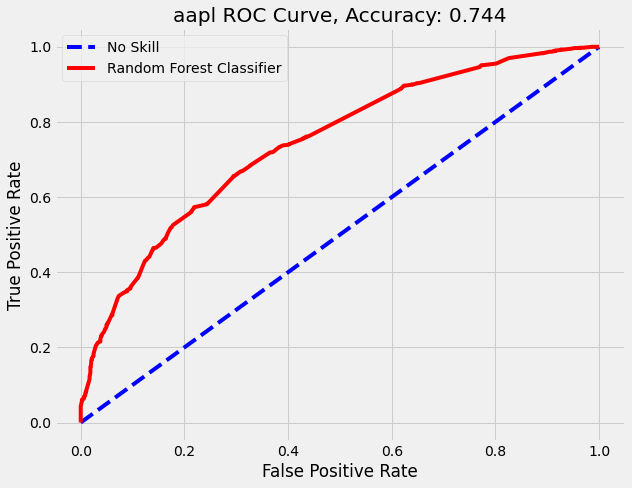

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

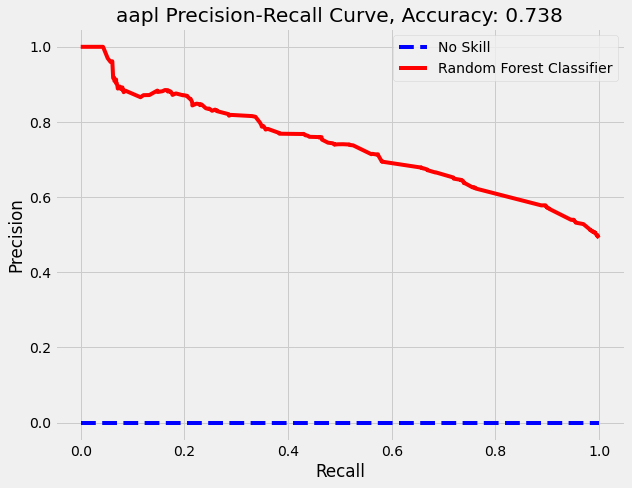

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

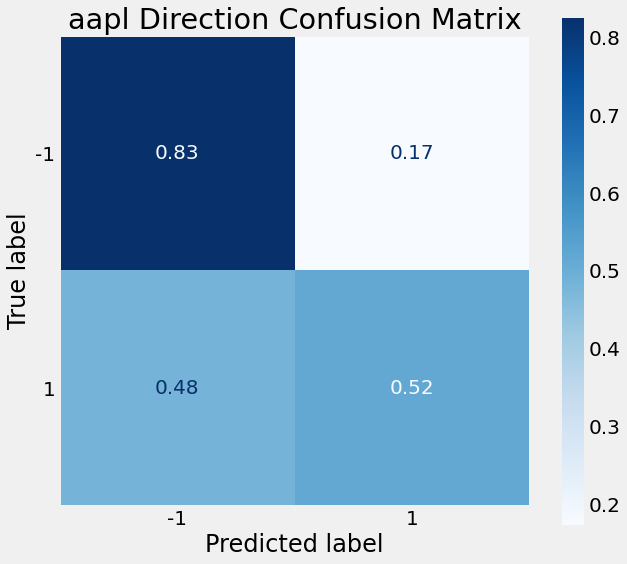

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.7021119483833218'

In [11]:
# Prediction, use last day of data
stock_df.iloc[-1]

High          1.373400e+02
Low           1.335100e+02
Open          1.339900e+02
Close         1.366900e+02
Volume        1.241829e+08
Adj Close     1.366900e+02
oc           -2.015073e-02
hl            2.868700e-02
adj           3.576571e-02
5stdev_adj    1.698702e-02
5sma_adj      1.547236e-02
direction    -1.000000e+00
Name: 2020-12-28 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-1]
last

oc           -0.020151
hl            0.028687
5stdev_adj    0.016987
5sma_adj      0.015472
Name: 2020-12-28 00:00:00, dtype: float64

### Prediction...

In [13]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name}')
else:
    print(f'Sell or hold {stock_name}')

Sell or hold aapl


In [14]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [15]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-21,128.309998,123.449997,125.019997,128.229996,121251600.0,128.229996,-0.025676,0.039368,0.012395,0.024494,0.010610,1,-1,-0.028465
2020-12-22,134.410004,129.649994,131.610001,131.880005,168904800.0,131.880005,-0.002052,0.036714,0.028465,0.016328,0.006285,-1,-1,0.006976
2020-12-23,132.429993,130.779999,132.160004,130.960007,88223700.0,130.960007,0.009080,0.012617,-0.006976,0.017229,0.004999,1,1,0.007712
2020-12-24,133.460007,131.100006,131.320007,131.970001,54930100.0,131.970001,-0.004950,0.018002,0.007712,0.017253,0.005149,1,-1,-0.035766
2020-12-28,137.339996,133.509995,133.990005,136.690002,124182900.0,136.690002,-0.020151,0.028687,0.035766,0.016987,0.015472,-1,-1,-0.000000


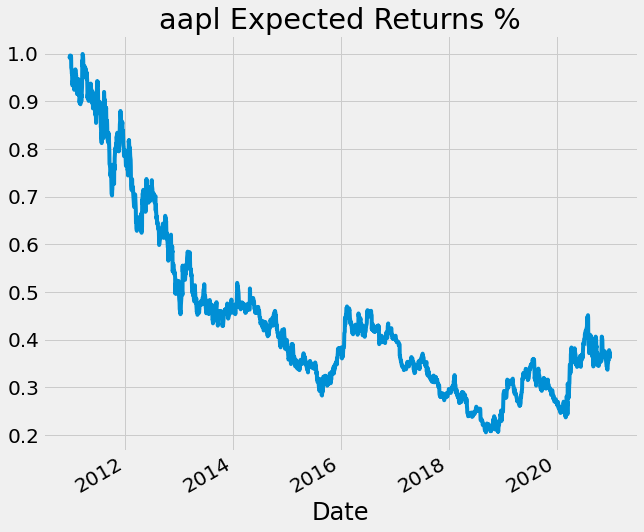

In [16]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [17]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

2.8082619957464594

In [18]:
# multiple times original investment, not bad but...

In [19]:
# If purchased in 2012 and left it until now
test_idx = int(len(stock_df)*0.75)
(stock_df['Close'][-1] - stock_df['Close'][-test_idx]) /stock_df['Close'][-test_idx]

374.6878462824963

In [20]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/